In [1]:
from tqdm import tqdm
import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import seaborn as sb


from simulator import simulate
from utils import generate_structures, get_bias

In [9]:
n_trials = 5
n_agents = 3 
n_sim = 100
emp_tau = 10
structures = generate_structures(n_agents) 

# specifying some observations 
a_obs = np.zeros(n_trials) 
b_obs = np.zeros(n_trials)
c_obs = np.zeros(n_trials)
a_obs[0] = 1
b_obs[0] = -1
c_obs[0] = 1
print(structures[:3])

[array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0]]), array([[0, 0, 0],
       [1, 0, 1],
       [1, 0, 0]])]


In [14]:
def start_sim(n_sim, struct, struct_idx): 
    res = {'A': {}, 'B': {}, 'C': {}, 'coms': {}}
    for sim_idx in range(n_sim):
        sim = simulate(n_trials, n_agents, struct, a_obs, b_obs, c_obs, emp_tau, sticky_weight=None, method='seqfilter')
        res['A'][sim_idx] = sim[0]
        res['B'][sim_idx] = sim[1]
        res['C'][sim_idx] = sim[2]
        res['coms'][sim_idx] = sim[3]
    sim_results[struct_idx] = res
    
sim_results = {}
for struct_idx in tqdm(range(len(structures[:3]))):
    start_sim(n_sim, structures[struct_idx], struct_idx)

100%|██████████| 3/3 [00:21<00:00,  7.11s/it]


In [15]:
# summary statistics 
mean_coms = {}
final_a = []
final_b = []

com = np.zeros((n_trials, n_agents))

for struct_idx in range(len(structures[:3])):
    mean_coms[struct_idx] = np.zeros((n_trials, n_agents))
    for trial in range(n_trials-1):
        a = []
        b = []
        for sim in range(n_sim):
            if trial == n_trials - 2: # get final trial for which we have evidence which is n_trials - 2
                a.append(sim_results[struct_idx]["A"][sim][trial][0])
                b.append(sim_results[struct_idx]["A"][sim][trial][1])
        if trial == n_trials - 2:
            final_a.append(a)
            final_b.append(b)
    for sim in range(n_sim):
        mean_coms[struct_idx] += sim_results[struct_idx]['coms'][sim]/n_sim
        
bias = get_bias(final_a, final_b, n_sim, structures[:3])

/var/folders/00/9xpq5wf91c52hxnyh5ythpw40000gn/T/ipykernel_27023/1892107633.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sb.kdeplot(a_bias, fill=True, ax=axs[i], color='red', path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
/var/folders/00/9xpq5wf91c52hxnyh5ythpw40000gn/T/ipykernel_27023/1892107633.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sb.kdeplot(b_bias, fill=True, ax=axs[i], color='deepskyblue', path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])


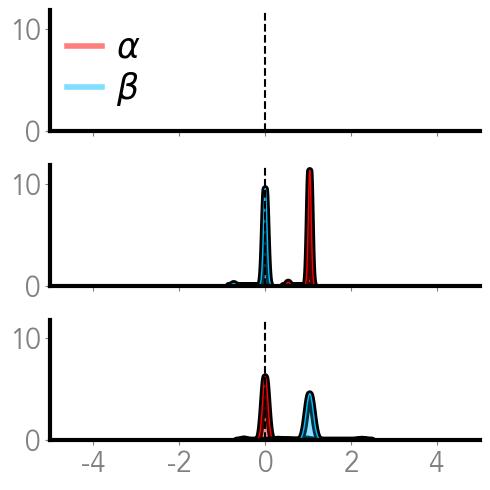

In [23]:
# plot
plot_params = {'legend.fontsize': 'large',
               'axes.labelsize': 'large',
               'axes.titlesize':'20',
               'axes.labelsize':'28',
               'xtick.labelsize':'20',
               'font.family': 'Avenir',
               'ytick.color':'grey',
               'xtick.color':'grey',
               'ytick.labelsize':'20',
               'axes.linewidth': '10'}

pylab.rcParams.update(plot_params)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_bias(names, data, n_rows, n_cols):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5,5), sharey=True) 
    struct_idx = 0
    for i in range(n_rows):
        for j in range(n_cols):  
            a_bias = smooth(data[0][struct_idx],2) # smoothing
            b_bias = smooth(data[1][struct_idx],2)
            sb.kdeplot(a_bias, fill=True, ax=axs[i], color='red', path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
            sb.kdeplot(b_bias, fill=True, ax=axs[i], color='deepskyblue', path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
            struct_idx += 1
            axs[i].axvline(x=0, label=r'$\mu$', color='black', linestyle='--')
            axs[i].set_xlim([-5, 5])
            # axs[i].set_ylim([-0.1, .6])
            # axs[i].set_yticks([0, 0.5])
            axs[i].set_xticks([-4,-2, 0, 2,4])
            axs[i].axhline(y=0, color='black', linestyle='--')
            if i == n_rows-1:
                axs[i].set_xticklabels([-4,-2, 0, 2,4])
            else:
                axs[i].set_xticklabels([])
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['bottom'].set_linewidth(3)
            axs[i].spines['left'].set_linewidth(3)
            axs[i].set_ylabel("")        
    custom_lines = [Line2D([0], [0], color='red', lw=4,mfc='black',alpha=.5),
                    Line2D([0], [0], color='DeepSkyBlue', lw=4,alpha=.5)]
    axs[0].legend(custom_lines, names, loc='upper left', 
                    fontsize=25, bbox_to_anchor=(-0.01, 1.0), 
                    ncol=1,frameon=False,borderpad=0.1, 
                    labelspacing=0.1, handlelength=1, 
                    handletextpad=0.4, columnspacing=0.4)
    fig.tight_layout()
    plt.show()

names = [r'$\alpha$', r'$\beta$']
plot_bias(names, bias, 3, 1)